# Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import string
import random
import re
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from termcolor import colored

from sentence_transformers import SentenceTransformer
s_model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWa

# Load survey data

In [2]:
# Read it in
path = "../data/surveys_clean_filtered.csv"
df = pd.read_csv(path, na_filter=False)

# Select responses categorized as "about race"
df_race = df[df['about_race'] > 0]

# Group by race
df_race_black = df_race[df_race['racial_group'] == "black"]
df_race_white = df_race[df_race['racial_group'] == "white"]
df_race = pd.concat([df_race_black, df_race_white])

# Get long responses
res_race_black = df_race_black['long'].tolist()
res_race_white = df_race_white['long'].tolist()
res_race = df_race['long'].tolist()

# Embed responses by treating each sentence separately

In [3]:
# Split responses into sentences
res_race_black_split = [
    # remove leading/trailing whitespace from r
    # split sentences of r at punctuation
    # remove empty strings resulting from regex
    list(filter(None, re.split("[.?!][ ]", r.strip())))
    for r in res_race_black
]

res_race_white_split = [
    list(filter(None, re.split("[.?!][ ]", r.strip())))
    for r in res_race_white
]

# Flatten, storing original indices
res_race_black_split_flat = []
for i in range(len(res_race_black_split)): # Response index
    for j in range(len(res_race_black_split[i])): # Sentence index within response
        s = res_race_black_split[i][j]
        res_race_black_split_flat.append((i,j,s))
        
res_race_white_split_flat = []
for i in range(len(res_race_white_split)):
    for j in range(len(res_race_white_split[i])):
        s = res_race_white_split[i][j]
        res_race_white_split_flat.append((i+len(res_race_black),j,s))
        
res_race_split_flat = res_race_black_split_flat + res_race_white_split_flat

# Embed
embed_race_black = np.transpose(
    s_model.encode(
        [r[2] for r in res_race_black_split_flat]
    )
)

embed_race_white = np.transpose(
    s_model.encode(
        [r[2] for r in res_race_white_split_flat]
    )
)

embed_race = np.concatenate((embed_race_black, embed_race_white), axis=1)

# Plot singular values

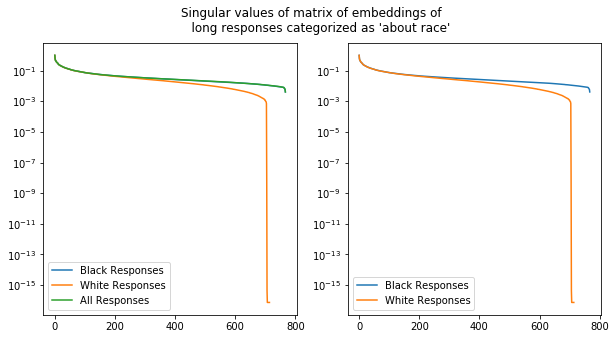

In [4]:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
fig.suptitle(
    """Singular values of matrix of embeddings of 
    long responses categorized as 'about race'"""
)

skip = 0
for A in [embed_race_black, embed_race_white, embed_race]:
    U,S,Vt = np.linalg.svd(A, full_matrices=False)
    S = [S[i]/S[0] for i in range(len(S))]
    axs[0].semilogy(S)
    if skip != 2:
        axs[1].semilogy(S)
    skip += 1

axs[0].legend(["Black Responses", "White Responses", "All Responses"])
axs[0].yaxis.set_tick_params(labelleft=True)

axs[1].legend(["Black Responses", "White Responses"])
axs[1].yaxis.set_tick_params(labelleft=True)

# CUR decomposition

In [5]:
# Modified CUR which only selects columns.
# Does not compute the U or R
def cur(A, idx=False, SVD=None, rank=None, p_C=None, use_random=False):
    
    if SVD==None:
        SVD = np.linalg.svd(A, full_matrices=False)
    if rank==None:
        rank = np.linalg.matrix_rank(A)
    
    V,S,Wt = SVD
    
    def DEIM(M, p=None):
        if not p:
            p = []
            p.append(np.argmax(np.abs(M[:,0])))
        for i in range(len(p),rank):
            res = M[:,i] - np.dot(M[:,:i],np.dot(np.linalg.inv(M[:,:i][p]), M[:,i][p]))
            p.append(np.argmax(np.abs(res)))
        return p
    
    p_C = random.sample(range(np.shape(A)[1]),rank) if use_random else DEIM(np.transpose(Wt), p_C)
    C = A[:,p_C]
    
    return (C,p_C) if idx else C

In [6]:
# Using DEIM selection
C_race_black, p_C_race_black = cur(embed_race_black, idx=True)
C_race_white, p_C_race_white = cur(embed_race_white, idx=True)
C_race, p_C_race = cur(embed_race, idx=True)

# Using random selection
C_race_black_random, p_C_race_black_random = cur(embed_race_black, idx=True, use_random=True)
C_race_white_random, p_C_race_white_random = cur(embed_race_white, idx=True, use_random=True)
C_race_random, p_C_race_random = cur(embed_race, idx=True, use_random=True)

# Is DEIM biased towards responses with more sentences?

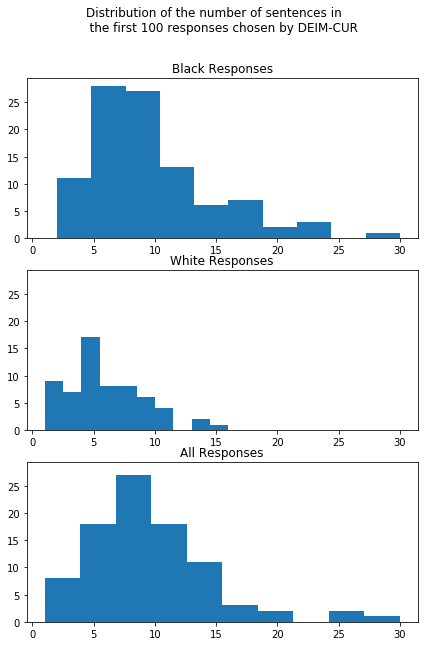

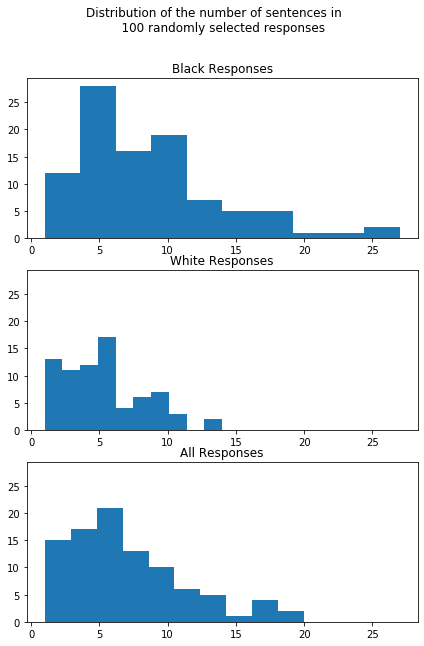

In [7]:
def plot_sentence_lengths(ax, p_C, res, title):
    found_idx = []
    lengths = []
    for i in p_C[:100]:
        idx = res[i][0]
        if idx not in found_idx:
            found_idx.append(idx)
            lengths.append(len(list(filter(None, re.split("[.?!][ ]", res_race[idx].strip())))))
    ax.hist([lengths])
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.set_title(title)

fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(7,10))
fig.suptitle(
    """Distribution of the number of sentences in 
    the first 100 responses chosen by DEIM-CUR"""
)

plot_sentence_lengths(axs[0], p_C_race_black, res_race_black_split_flat, "Black Responses")
plot_sentence_lengths(axs[1], p_C_race_white, res_race_white_split_flat, "White Responses")
plot_sentence_lengths(axs[2], p_C_race, res_race_split_flat, "All Responses")

fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(7,10))
fig.suptitle(
    """Distribution of the number of sentences in 
    100 randomly selected responses"""
)

plot_sentence_lengths(axs[0], p_C_race_black_random, res_race_black_split_flat, "Black Responses")
plot_sentence_lengths(axs[1], p_C_race_white_random, res_race_white_split_flat, "White Responses")
plot_sentence_lengths(axs[2], p_C_race_random, res_race_split_flat, "All Responses")

# Highlight sentences in the responses they appear

In [8]:
for i in p_C_race[:100]:
    sen = res_race_split_flat[i][2]
    res = res_race[res_race_split_flat[i][0]]
    race = df_race['racial_group'].iloc[res_race_split_flat[i][0]]
    print(colored(race, 'blue', attrs=['bold']))
    for s in list(filter(None, re.split("[.?!][ ]", res.strip()))):
        if s == sen:
            print(colored(s, 'red', attrs=['bold']))
        else:
            print(s)
    print()

black
in order to make a soldier feel that he has something to fight for
he should be near his home town or near some big city
where he can see and realize what he must fight to try and hold
to stop the ruff treatment of soldiers in southern states would help very much in every negro mind that he really has something to fight for if a man feels that he is being treated right
he can do far better than if he thinks he is not
it is hard to fight another country when we are fighting among our selves
and trying to keep the darker race down because of color
we the negro people are of different color
but of the same material under neath as the white
and if we are giving the chance we can do the same things which have been poorer in some cases
lets stop putting white mp over colored soldiers
and shooting and beating them

black
for that one great cause only
in other words we are fighting for the same thing
the negro are paying for this war as well as the white with their lives and blood
so why

i would like to call this propaganda but the rumor is colored combat troops are only formed as an appeasement to the race at home, i only wonder!



# Error plots

In [13]:
def plot_error(A, title, axs=None):
    V,S,Wt = np.linalg.svd(A, full_matrices=False)
    rank = np.linalg.matrix_rank(A)
    print("Rank:", rank)
    
    eta_c = np.zeros(rank)
    norm = np.zeros(rank)
    norm_random = np.zeros(rank)
    sig = np.zeros(rank)
    
    p_C_k = [] # track pre-selected columns from previous iterations
    
    A_k = np.zeros(A.shape)
    for k in range(rank):
        SVD_k = (V[:,:k+1],S[:k+1],Wt[:k+1,:])
        A_k = (SVD_k[0] * SVD_k[1][...,None,:]) @ SVD_k[2]
        
        C_k, p_C_k = cur(A, idx=True, SVD=(V,S,Wt), rank=k+1, p_C=p_C_k)
        C_k_random, p_C_k_random = cur(A, idx=True, SVD=(V,S,Wt), rank=k+1, use_random=True)
        
        WtF_k = SVD_k[2][:k+1,:][:,p_C_k[:k+1]]        
        eta_c[k] = np.linalg.norm(np.linalg.inv(WtF_k))
        
        X_k = np.linalg.pinv(C_k) @ A
        X_k_random = np.linalg.pinv(C_k_random) @ A
        
        norm[k] = np.linalg.norm(A - C_k@X_k)
        norm_random[k] = np.linalg.norm(A - C_k_random@X_k_random)
        
        sig[k] = np.linalg.norm(A - A_k)
        
        if k%100==0:
            print("Progress:",k,"/",rank)
            
    fig, axs = plt.subplots(2,2, figsize=(10,10))
    fig.suptitle(title)
    
    axs[0][0].scatter(range(rank), eta_c)
    axs[0][0].scatter(range(rank), norm)
    axs[0][0].scatter(range(1,rank+1), sig, marker='o', facecolors='none', edgecolors='g')
    axs[0][0].set(xlabel='k')
    axs[0][0].legend(["(eta_c)_k", "|| A - C_k(X_k) ||", "sigma_k"])
    axs[0][0].set_title('Using DEIM selection')
    
    axs[0][1].scatter(range(100), (norm[:100]-sig[:100])/sig[:100])
    axs[0][1].set(xlabel='k')
    axs[0][1].legend(["(|| A - C_k(X_k) || - sigma_(k+1)) / sigma_(k+1)"])
    axs[0][1].set_title('Using DEIM selection')
    
    axs[1][0].scatter(range(rank), norm_random)
    axs[1][0].scatter(range(1,rank+1), sig, marker='o', facecolors='none', edgecolors='g')
    axs[1][0].set(xlabel='k')
    axs[1][0].legend(["|| A - C_k(X_k) ||", "sigma_k"])
    axs[1][0].set_title('Using random selection')
    
    axs[1][1].scatter(range(100), (norm_random[:100]-sig[:100])/sig[:100])
    axs[1][1].set(xlabel='k')
    axs[1][1].legend(["(|| A - C_k(X_k) || - sigma_(k+1)) / sigma_(k+1)"])
    axs[1][1].set_title('Using random selection')

Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768
Rank: 705
Progress: 0 / 705
Progress: 100 / 705
Progress: 200 / 705
Progress: 300 / 705
Progress: 400 / 705
Progress: 500 / 705
Progress: 600 / 705
Progress: 700 / 705
Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768


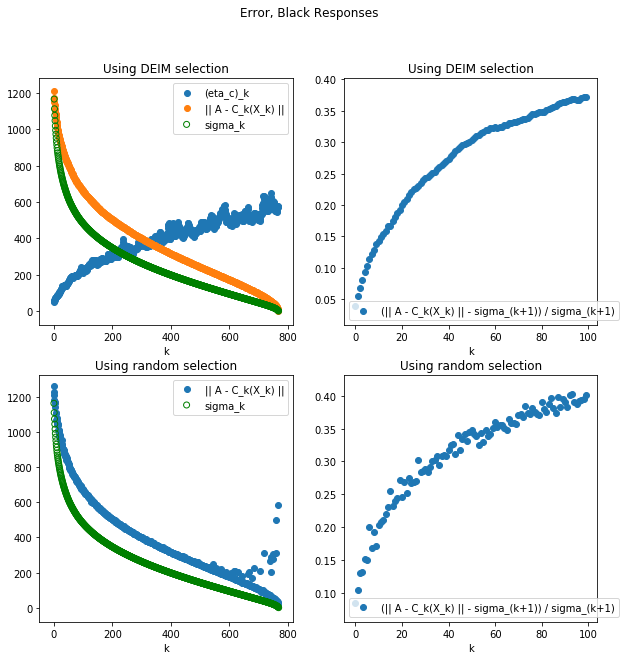

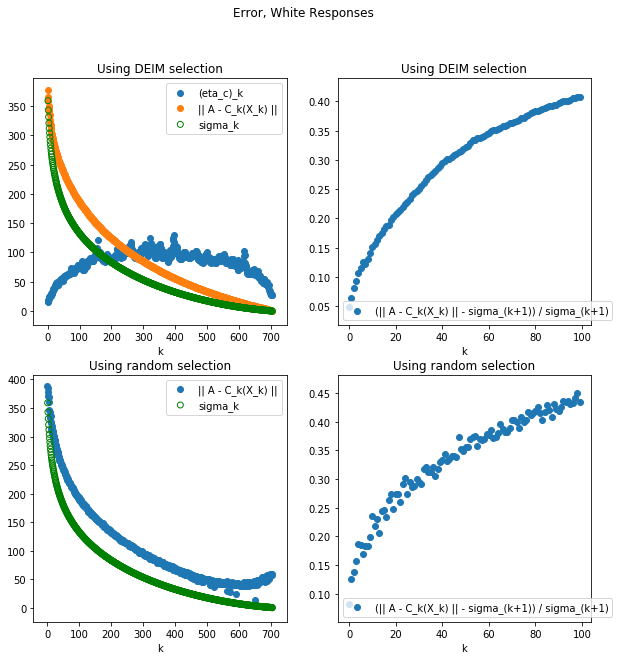

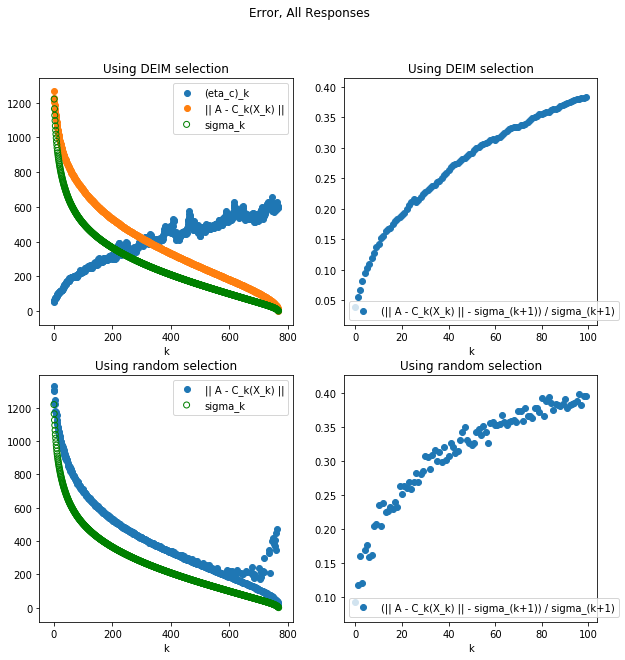

In [14]:
plot_error(embed_race_black, "Error, Black Responses")
plot_error(embed_race_white, "Error, White Responses")
plot_error(embed_race, "Error, All Responses")